In [1]:
import configparser
import os
import sys
from time import sleep
from uuid import uuid4

import numpy as np

import GCode
import GRBL

# Laser Shading By adjusting focus on the Z-axis

# Code:

In [2]:
# Poplar 1x4". Cut
BlockHeight = 89.0  # [mm]
BlockLength = 2 * BlockHeight  # [mm]
BlockThickness = 19.0  # [mm]
print("{} x {} x {}".format(BlockHeight, BlockLength, BlockThickness))


89.0 x 178.0 x 19.0


In [3]:
config = configparser.ConfigParser()
config["GRBL"] = dict()
config["GRBL"]["port"] = "/dev/cnc_3018"
cnc = GRBL.GRBL(**config["GRBL"])

cnc.reset(home=True)


(4, ['', "Grbl 1.1f ['$' for help]", "[MSG:'$H'|'$X' to unlock]"])

In [5]:
status = cnc.status
while "Alarm" in status:
    cnc.home()
    status = cnc.status

# Generate Program

Generate the G-code program that will test how the laser focus affects shading.

- Laser 'focused' at -14mm.
- Testing 17 positions between [-28, 0]
- Testing 3 different feed rates [100, 200, 300]
- Testing 5 different power settings between [100, 255]

In [6]:
# Define a gap between horizontal lines
vgap = 5  # [mm]
# Generate a list of horizontal line vertical coordinates
vs = np.arange(vgap, BlockHeight, vgap)
vs


array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65.,
       70., 75., 80., 85.])

In [7]:
# Define a horizontal distance to test lazerin.
hgap = 10  # [mm]
hs = np.arange(0, BlockLength, hgap)
hs


array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170.])

In [8]:
# Total travel range, starts at ztravel, ends at 0. "negative space"(?)
ztravel = -28
# Generate a number of z-axis test positions.
# Each z-height will have 10 mm marked at the given feed rate and power.

# Generate the full list of z-stops from the initial test.
zs_ = np.linspace(start=ztravel, stop=0, num=len(hs) - 1, endpoint=True)
# Generate a narrower list of z-stops where the laser worked.
zs = np.linspace(start=zs_[5], stop=zs_[13], num=len(hs) - 1, endpoint=True)
zs

array([-19.25 , -18.375, -17.5  , -16.625, -15.75 , -14.875, -14.   ,
       -13.125, -12.25 , -11.375, -10.5  ,  -9.625,  -8.75 ,  -7.875,
        -7.   ,  -6.125,  -5.25 ])

In [9]:
# Laser powers to test.
powers = [255, 200, 150]
powers


[255, 200, 150]

In [10]:
feeds = [50, 100, 150, 200, 300]

In [11]:
def init2(**kwargs):
    program = GCode.GCode(**kwargs)
    program.G0(F=500)
    program.G1(F=500)
    program.G21()  # Metric Units
    program.G90()  # Absolute positioning.
    return program

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Plot one move

Each of the ```for``` loops is broken so only plot the first laser program.

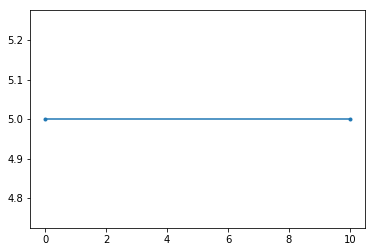

In [14]:

plt.figure()
ax1=plt.subplot(1,1,1)
programs = list()
for idx1, power in enumerate(powers): # [uint8 duty cycle]
    for idx2, feed in enumerate(feeds):  # [mm/min]
        v_idx = idx1 * len(powers) + idx2
        Y = vs[v_idx]
        for idx3, z in enumerate(zs):
            x0 = hs[idx3]
            xf = hs[idx3 + 1]
            ax1.plot(np.array([x0, xf]), np.array([Y, Y]), marker='.')
            break
        break
    break

Remove one set of breaks.

This is one entire horizontal line where each color represents a different Z-axis height.

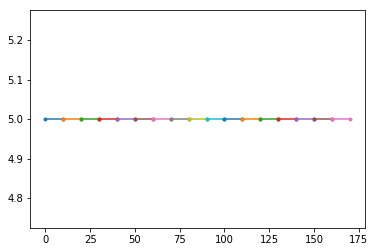

In [15]:
plt.figure()
ax1=plt.subplot(1,1,1)
programs = list()
for idx1, power in enumerate(powers): # [uint8 duty cycle]
    for idx2, feed in enumerate(feeds):  # [mm/min]
        v_idx = idx1 * len(powers) + idx2
        Y = vs[v_idx]
        for idx3, z in enumerate(zs):
            x0 = hs[idx3]
            xf = hs[idx3 + 1]
            ax1.plot(np.array([x0, xf]), np.array([Y, Y]), marker='.')
        break
    break

Plot everything.

Starting at the bottom (0, 5) each horizontal line has fixed feed rate and power.

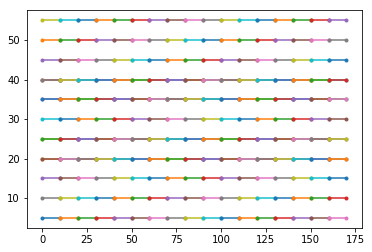

In [17]:
plt.figure()
ax1=plt.subplot(1,1,1)
programs = list()
for idx1, power in enumerate(powers): # [uint8 duty cycle]
    for idx2, feed in enumerate(feeds):  # [mm/min]
        v_idx = idx1 * len(powers) + idx2
        Y = vs[v_idx]
        for idx3, z in enumerate(zs):
            x0 = hs[idx3]
            xf = hs[idx3 + 1]
            ax1.plot(np.array([x0, xf]), np.array([Y, Y]), marker='.')

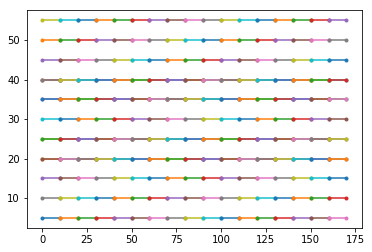

In [18]:
plt.figure()
ax1=plt.subplot(1,1,1)
programs = list()
for idx1, power in enumerate(powers): # [uint8 duty cycle]
    for idx2, feed in enumerate(feeds):  # [mm/min]
        v_idx = idx1 * len(powers) + idx2
        Y = vs[v_idx]
        for idx3, z in enumerate(zs):
            x0 = hs[idx3]
            xf = hs[idx3 + 1]
            ax1.plot(np.array([x0, xf]), np.array([Y, Y]), marker='.')
            
            program = init2(machine=cnc)
            program.G0(Z=z, Y=Y, X=x0)
            program.M4(S=power)
            program.G1(X=xf, Y=Y, Z=z, F=feed)
            program.M5()  # Laser. Off.
            programs.append(program)

In [22]:
programs[4]

<GCode>[cmds=8]

In [ ]:
programs


In [ ]:
programs[17]


In [ ]:
zs[0]


In [ ]:
zs[5]


In [ ]:
zs[13]


In [ ]:
for idx, program in enumerate(programs):
    print("{}:".format(idx))
    program.machine = cnc
    program.run()


In [ ]:
cnc.status
